# **Problem set 2** - Machine Learning for Physics and Astronomy 2023/2024, UvA
---




## Kaya Han Taş - 15064735 (Astronomy & Astrophysics)

- The total sheet gives 26 points
- Deadline for submitting your results is **Wed 17/04/2024, 23:59**
- **IMPORTANT**: Specify if/how AI was used to solve the exercises by filling the corresponding "Usage of AI" comments. Anything between "No" (if applicable) and a short paragraph reflecting how AI was used is fine. Failing to do so faithfully will result in the substraction of points.

## Chapter 3: Inference and Bayes nets (16 points)

### 3.1 Inverse Sampling (2 points)

*Topics: Inverse transform sampling*

**Reading material: Murphy 23.2.1**

(2 points) Consider the target exponential pdf $p(x)=\lambda e^{-\lambda x}$, where $\lambda$ is the rate parameter. Define a function that, using the inverse transform method, generates samples from the exponential distribution.

Choosing $\lambda =0.5$ and a sample size of $1000$, plot the histogram of the sampled data and overlay the theoretical exponential distribution curve on top.

Hint: You will need to use the function `np.random.uniform`

### Answer:

* First, let's look at the reading material from 23.2.1 to understand what the **Inverse Transform Method** is.

* The simplest method for sampling from a **univariate distribution** is based on the **Inverse Probability Transform Method**.
* We define the following:
    * $F$: A CDF of some distribution we want to sample from.
    * $F^{-1}$: Inverse of the CDF.

* By defining these we get the following result...
* **If $U \sim U(0,1)$ is a Uniform Random Variable (rv)**:
$$ F^{-1}(U) \sim F $$

* Hence, **we can sample from any Univariate Distribution** for which **we can evaluate its inverse CDF as follows**:
    * 1-) **Generate a Random Number using a Pseudo Random Number Generator:** $u \sim U(0,1)$
    * 2-) **Let $u$ represent the height up the $y$-axis.**
    * 3-) **"Slide along" the $x$-axis until you intersect the $F$ Curve!**
    * 4-) **"Drop Down" and return to the corresponding $x$ value.**
    * 5-) **This corresponds to computing $x = F^{-1}(u)$.**
    * 6-) **This is basically "Root Finding" but inverse.**

* For example, consider the Exponential Distribution of the following: (**Note that this is the Distribution that is asked in the question!!!**)

$$ \exp(x|\lambda) = \lambda e^{-\lambda x} $$
$$ (x \ge 0) $$

<h5><center> Note: In the book the $(x \ge 0)$ expression is given with "Indicator Function" which is shown as $I$ but we don't use that notation in our explanation here. Indicator Function basically indicates that the function is equal to the expression when $(x \ge 0)$.</h5>

* It's CDF is the following:

$$ F(x) = 1 - e^{-\lambda x}$$
$$ (x \ge 0) $$

* This **CDF's Inverse is the Quantile Function:**

$$ F^{-1}(p) = -\frac{\ln(1-p)}{\lambda} $$

* By the theorem above:
    * **If $U \sim U(0,1)$:** We know that $F^{-1}(U) \sim \exp(\lambda)$.

* Furthermore:
    * **Since $1-U \sim U(0,1)$ as well:**
        * We can sample from the Exponential Distribution by **first sampling from Uniform distribution**.
        * Then **transforming the results using $-\ln(u)/\lambda$**.

* Now we can start coding what we have discussed.

In [1]:
#First we import Numpy and Matplotlib.
import numpy as np
import matplotlib.pyplot as plt

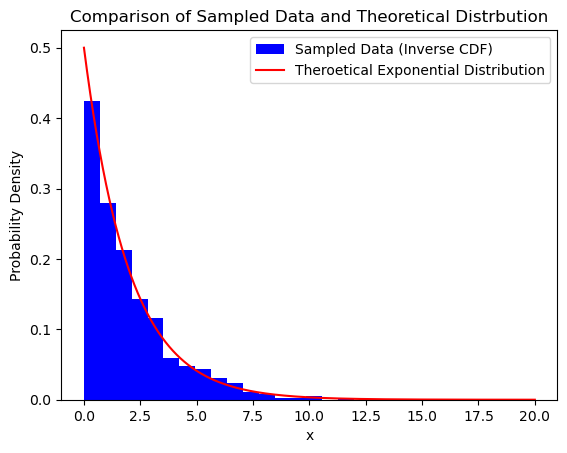

In [2]:
#Now using the topic we have discussed, we can write the Inverse Transform function as follows.
def inverse_transform(rate, sample_size):
    """Takes the rate (lambda) and the amount of samples we want to generate.
    Depending on the sample_size, generates an amount of random samples from the 
    Uniform distribution. Uses Exponential Distribution CDF's Inverse function 
    transform the Uniform Samples we have generated. Returns the tranformed 
    samples.
    
    Input:
    ----------------------------------------------------------------------------
    rate: Rate Parameter which is given with lambda on mathematical expressions
    above.
    sample_size: Amount of samples that will be generated from the Uniform
    Distribution and get transformed.
    
    Output:
    ----------------------------------------------------------------------------
    transformed_samples: A Numpy Array containing the transformed samples.
    
    """

    #We first get random samples from uniform distribution using np.random.uniform().
    random_samples = np.random.uniform(size = sample_size)

    #Then we transform these Random Uniform samples by using the Inverse of the CDF.
    transformed_samples = -np.log(1 - random_samples) / rate

    return transformed_samples

#In the question the Rate and the Sample Size is given as follows.
rate = 0.5
sample_size = 1000

#Using these we can get the transformed samples as follows.
transformed_samples = inverse_transform(rate, sample_size)

#Now we also need to define the theroetical Exponential Distribution to compare our sampled data with the
#real function/distribution.
#For this, we first define some x values.
x_values = np.linspace(0, 20, 1000)

#We now define the theoretical Exponential Distribution.
exp_dist = rate * np.exp(-rate * x_values)

#We can now create and plot our histogram for the samples as follows.
plt.hist(transformed_samples, bins = 20, density = "True", color = "blue", label = "Sampled Data (Inverse CDF)")

#We also plot our Theoretical Exponential Distribution.
plt.plot(x_values, exp_dist, color = "red", label = "Theroetical Exponential Distribution")

#We also add labels, title and show legend as follows.
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Comparison of Sampled Data and Theoretical Distrbution")
plt.legend(loc = "upper right")

plt.show()

Usage of AI: *Used to optimize the code.*

### 3.2 Metropolis Hastings & credible intervals (10 points)



*Topics: Multivariate normal, Metropolis Hastings and marginal distributionsm Credible intervals, Highest posterior density region*

**Reading material: Murphy 5.2.2, 5.2.2.1, 24.3**

We will explore a 2-dim and bimodal probability density function.

In [3]:
# provided

# The likelihood function is given

def pdf_bimodal(x):
    """Bimodal pdf"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/((2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2).sum()/sigma1**2)  +  0.5/((2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2).sum()/sigma2**2)
    return pdf


### Answer (Introduction to the Question & Reading Material):

* We again start by talking about the reading material first to get an understanding of what we need to do.

#### 5.2.2 - Credible Intervals

* In addition to point estimates, we often want a **measure of confidence**.
* **A standard measure of confidence in some (scalar) quantity $\theta$ is:**
    * **The width of its Posterior Distribution!**

* This can be measured using a $100(1-\alpha)\%$ **Credible Interval!**
* This is a (contiguous) **region $C = (l, u)$ that contains $1 - \alpha$ of the Posterior Probability Mass**.
* In here:
    * $l$: Lower
    * $u$: Upper

* The **Credible Interval** can be given by the following expression:

$$ C_{\alpha}(D) = (l,u) $$
$$ P(l \le \theta \le u | D) = 1 - \alpha$$

* There may be such intervals like the one above.
* For that reason **we choose an interval such that there is $(1-\alpha)/2$ Mass in each tail!**
* That's what we call **Central Interval!**

* **If the Posterior has a known Functional form**, we can **compute the Posterior Central Interval** using the following:

$$ l = F^{-1}(\alpha/2) $$
$$ u = F^{-1}(1 - \alpha/2) $$

<h5><center> In here $F$ is the CDF of the Posterior Distribution! </h5>

* For example if the **Posterior is Gaussian and $\alpha = 0.05$** we would get the following:

$$ p(\theta|D) = \mathcal{N}(0,1) $$
$$ \alpha = 0.05 $$

<h5><center> Denoting that $\Phi$ is the CDF of the Gaussian! </h5>

$$ l = \Phi(\alpha/2) = -1.96 $$
$$ u = \Phi(1 - \alpha/2) = 1.96 $$

* This justifies the common practice of **quoting Credible Interval in the form of:**

$$ \mu \pm 2\sigma $$

<h5><center> $\mu$: Posterior Mean </h5>
<h5><center> $\sigma$: Posterior Standard Deviation </h5>
<h5><center> $2$: Good Approximation to the $1.96$ value we have obtained previously. </h5>

* Of course, the Posterior is not always Gaussian.
* For Example, in a coin toss, **if we use a Uniform Prior** and we observe $N_{1} = 47$ Heads out of $N = 100$ Trials:
$$ p(\theta|D) = Beta(48, 54) $$

* From here we find the **$ \%95 $ Posterior Credible Interval** is:
$$ (0.3749, 0.5673) $$

* **If we don't know the Functional form, but can Draw Samples from the Posterior:**
    * Then we can use a **Monte Carlo Approximation to the Posterior Quantiles!**

* **How Monte Carlo Approximation for Posterior Quantiles works is:**
    * 1-) **We sort the $S$ samples!**
    * 2-) **We find the one that occurs at location $\alpha/S$ along the sorted list!**
    * 3-) **As $S \rightarrow \infty$ this converges to *True Quantile***

#### 5.2.2.1 - Highest Posterior Density Regions

* A problem with Central Intervals is that **there might be points outside the Confidence Interval (CI) which have higher Probability Density.**
* This can be seen below where we see that points outside the Left Most CI have higher density than those just inside the Right-Most CI Boundary.

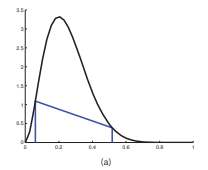|
-
<h5><center> Central Interval Region for a $Beta(3,9)$ Posterior</h5>
<h5><center> Confidence Interval (CI) is at $(0.06, 0.52)$.</h5>

* This motivates an **alternative quantity** known as the **Highest Posterior Density** or **HPD** region!
* **Highest Posterior Density (HPD):**
    * Defined as ***the set of most probable points that in total consitute $100(1-\alpha)\%$ of the Probability Mass!***

* More formally, **we find the threshold on $p^*$ on the PDF such that:**

$$ 1-\alpha = \int_{\theta:p(\theta|D)>p^*} p(\theta|D) d\theta $$

* From here **we define HPD as follows:**

$$ C_\alpha(D) = \{ \theta:p(\theta|D) \ge p^* \} $$

* In 1 Dimension, HPD region is sometimes called a **Highest Density Interval (HDI)!**
* We can see an example of **HPD** on the graph below:

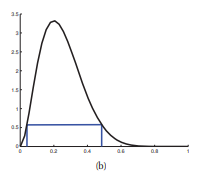|
-
<h5><center> Highest Posterior Density (HPD) Region for a $Beta(3,9)$ Posterior</h5>
<h5><center> Highest Posterior Density (HPD) is at $(0.04, 0.48)$.</h5>

* We see that **this is narrower than the Confidence Interval (CI) which was at $(0.06, 0.52)$, *even though it still contains the $\%95$ of the Mass!***
* Furthermore: ***Every point inside of it has Higher Density than every point outside of it!***

* **For a Unimodal Distribution:**
    * 1-) **HDI will be the Narrowest Interval around the Mode.**
    * 2-) **It will contain %95 of the Mass!**

* For this to be understandable:
    * 1-) Imagine "Water Filling" in reverse.
    * 2-) We lower the level until %95 of the mass is revealed and only %5 is submerged.
    * 3-) This gives a **simple algorithm for computing HDIs in 1 Dimensional case!**

* **To calculate HDIs in 1 Dimension:**
    * 1-) Search over points such that **the interval contains %95 of the Mass and has minimal width!**
    * 2-) This can be done by **1-D Numerical Optimization if we know the inverse CDF of the distribution!**
    * 3-) We can also do this by **searching over the sorted Data Points if we have a bag of Samples!**

* If the Posterior is multimodal:
    * The HDI may not even be a connected region!
    * However, summarizing multimodal posteriors is always difficult.

#### 24.3 - Metropolis Hastings Algorithm

#### 24.3.1 - Basic Idea

* **The basic idea in Metropolis Hasting (MH):**
    * 1-) At each step **we propose to move from the current state $x$ to a new state $x^\prime$ with Probability $q(x^\prime|x)$!**
    * 2-) $q$ is called the **Proposal Distribution!** (also called the **kernel**)
    * 3-) The user is free to use **any kind of proposal they want, subject to some conditions which we will explain below.**

* This makes MH quite a flexible method.
* A commonly used proposal is a **symmetric Gaussian Distribution centered on the current state!**

$$ q(x^\prime|x) = \mathcal{N}(x^\prime|x,\Sigma) $$
<h5><center> Random Walk Metropolis Algorithm </h5>

* This is called a **Random Walk Metropolis Algorithm!**
* They discuss how to choose $\Sigma$ in book's Section 24.3.3.

* If we use a **proposal of the form $q(x^\prime|x) = q(x^\prime)$**:
    * 1-) **The New State is independent of the Old State.**
    * 2-) We get a method known as the **Independence Sampler!**
    * 3-) This is similar to Importance Sampling.

* Having proposed a move to $x^\prime$:
    * 1-) We then **decide whether to Accept this proposal or not!**
    * 2-) For this **we use a formula!**
    * 3-) This ensures that the **fraction of time spent in each state is proportional to $p^{*}(x)$.**

* **If the proposal is accepted:**
    * **The new state is $x^\prime$!**

* **If the proposal is denied:**
    * **The new state is same as the current state $x$!**
    * So we repeat the sample.

* **If the Proposal is symmetric:**
    * $q(x^\prime|x) = q(x|x^\prime)$

* **For a Symmetric Proposal the Acceptance Probability is given with the following formula:**

$$ r = min\left( 1, \frac{p^*(x^\prime)}{p^*(x)} \right) $$

* Note that if the following is satisfied, **we definitely move to a new state!**

$$ r = min\left( 1, \frac{p^*(x^\prime)}{p^*(x)} \right) > 1 $$
<h5><center> Condition to definitely move to a New State! </h5>

* We see here that:
    * 1-) **If $x^\prime$ is more probable than $x$:**
        * **We definitely move there!**
    * 2-) **If $x^\prime$ is less probable than $x$:**
        * **We may still move there anyway!**
        * **This of course depends on the relative probabilities!**

* So instead of greedily moving to only more probable states:
    * **We occasionally allow "Downhill" moves to less probable states!**
    * This procedure **ensures that the fraction of time we spend in each state $x$ is proportional to $p^{*}(x)$!**

* **If the Proposal is Asymmetric:**
    * $q(x^\prime|x) \neq q(x|x^\prime)$

* For Asymmetric Proposals **we need the Hastings Correction**!
* **Hastings Correction** is given by the following equations:

$$ r = min(1, \alpha)$$
$$ \alpha = \frac{p^{*}(x^\prime) q(x|x^\prime)}{p^{*}(x)q(x^\prime|x)} $$

* Hastings Correction is **needed to compensate for the fact that the Proposal Distribution itself** (rather than just the Target Distribution) **might favor certain states!**

* **An Important Reason why MH is a useful algorithm is that:**
    * 1-) When evaluating $\alpha$, we only need to **know the Target Density up to a Normalization Constant!**

* An example can be given by the following:

$$ p^{*}(x) = \frac{1}{Z} \overline{p}(x) $$
<h6><center> $\overline{p}(x)$: An Unnormalized Distribution</h6>
<h6><center> $Z$: Normalization Constant</h6>
<h5><center> From here $\alpha$ becomes the following:</h5>
$$ \alpha = \frac{(p^{*}(x^\prime)/Z) q(x|x^\prime)}{(p^{*}(x)/Z) q(x^\prime|x)} $$
<h5><center> $Z$ terms cancel out!</h5>

* **We can sample from $p^{*}$ even if $Z$ is unknown!**
* **All we have to do is evaluate $\overline{p}$ pointwise where $\overline{p} = p^{*}(x)Z$**

* We can summarize the Metropolis Hastings Algorithm by the following Table:

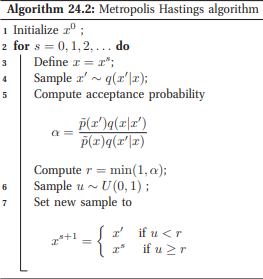|
-

* Now we go back to our question.

We will explore a 2-dim and bimodal probability density function.

In [4]:
# provided

# The likelihood function is given

def pdf_bimodal(x):
    """Bimodal pdf"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/((2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2).sum()/sigma1**2)  +  0.5/((2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2).sum()/sigma2**2)
    return pdf


1. Write your own Metropolish Hastings algorithm. (4 points)

- The proposal distribution is supposed to be a $D=2$ dimensional isotropic Gaussian with variance $\sigma^2$.
- Given some pdf, the algorithm should produce and return a given number of chain points $N$, starting with some initial vector $\mathbf{x}_0$. The result should be returned as a $N\times D$ array.
- The algorithm should also evaluate and print the acceptance rate (fraction of accepted transitions over total number of steps).

Hints: Use `np.random.randn`, `np.random.rand`, `np.array` where appropriate. Write the algorithm such that it works for any dimensions of $\mathbf{x}_0$.

### Answer:

In [5]:
#We define the Metropolis Hastings "Chain" as a function as follows.
def MetropolisHastings(pdf, N, x_init, sigma):
    """The target distribution's PDF, the amount of Chain Points user aims for,
    Initial Vector (or point) and the proposal distribution's (which is an
    Isotropic Distribution) variance. Returns a numpy array containing the Chain
    Points with N x D size where D is the dimension of the Proposal Distribution
    i.e. initial vector.
    
    Input:
    ----------------------------------------------------------------------------
    pdf: The Probability Density Distribution of the Target Distribution.
    N: Amount of Chain Points.
    x_init: Initial Vector (starting point) of our Chain.
    sigma: The variance of the Proposal Distribution which is an Isotropic Gaussian 
    Distribution.
    
    Output:
    ----------------------------------------------------------------------------
    chain_points: A Numpy Array containing the Chain Points, obtained by the
    Metropolis Hastings Algorithm.
    acceptance_rate: The fraction of accepted transitions over the total number of
    steps i.e. number of chain points (N-1).
    
    """

    #We first get the Dimensions of the result numpy array.
    #N is given by the User.
    #D we can find by checking the length of the initial point/vector.
    D = len(x_init)

    #We can now define a Numpy Array of zeroes with N x D dimensions to store all the chain points!
    chain_points = np.zeros((N, D))

    #We also need a count for the accepted points to find the acceptance rate.
    #To keep count, we define the following.
    accepted_point_count = 0

    #We have finished our initial setup for the functions output and acceptance rate.
    #Now we need to define our first chain point outside of the loop.
    #This is our first and current state!
    x_current = np.array(x_init)

    #Now our goal is to go over the given amount of Chain Points that the user wants and store them on the
    #numpy array of chain_points.
    for i in range(0, N):
        #For our first/initial point, we put it onto our array right away without going into the loop.
        if i == 0:
            chain_points[0] = x_current
            
            #We skip the rest of the loop for the initial point.
            continue

        #We first generate the new proposed point from the Proposal Distribution which is an Isotropic
        #Gaussian Distribution. (Random Walk Metropolis Algorithm)
            #Note that np.random.randn() samples a random value from Standard Normal Distribution.
            #D is used to sample a value that has the same shape as our initial vector/point!
        x_new = x_current + sigma * np.random.randn(D)

        #Now we check the acceptance probability.
        #For this we first calculate the Acceptance Probability alpha.
        alpha = pdf(x_new) / pdf(x_current)

        #Then we use r = min(1, alpha) formula to calculate a condition for accepting or denying the new
        #proposed point.
        r = min(1, alpha)

        #We accept the new proposed point with probability of r.
        #Like the algorithm table shows us, we first sample from Uniform Distribution.
        #If it is smaller than r, we will accept the new point.
        #If it is larger or equal to r, we will deny the new point.
            #Note that np.random.rand() samples from Uniform Distribution so between 0 and 1.
        if np.random.rand() < r:
            x_current = x_new
            accepted_point_count += 1

        #Now that we have checked the condition, we add our current chain point onto our numpy array that
        #stores the chain points.
        chain_points[i] = x_current

    #We now calculate the Acceptance rate as follows.
        #Note that N-1 is used since the first point is already accepted.
    acceptance_rate = accepted_point_count / (N - 1)

    return chain_points, acceptance_rate

2. Explore the above bimodal distribution. (3 points)
- Show resulting chain for $N=10000$ and for five proposal widths in the range $\sigma \in [0.01, 100.]$.  
- Based on the acceptance rate and visual inspection of the result, argue what parameters work here best.
- What are the problems with too low or too high values of $\sigma$?
- Also discuss what happens when you start with initial values far away from the optimum. This initial phase is called "burn in phase".

Hints: use `plt.scatter`

### Answer:

--------------------------------------------------
For σ = 0.01:
--------------------------------------------------
Chain Points: [[ 0.          0.        ]
 [ 0.01400344 -0.01426629]
 [ 0.02132576 -0.01889359]
 ...
 [-0.3256404  -0.04968464]
 [-0.32807679 -0.04008385]
 [-0.3413498  -0.04045044]]
--------------------------------------------------
Acceptance Rate: 99.09%
--------------------------------------------------
--------------------------------------------------
For σ = 1:
--------------------------------------------------
Chain Points: [[ 0.          0.        ]
 [ 1.24679699 -0.92389342]
 [ 2.22116119  0.32918069]
 ...
 [ 2.25025151  1.48882178]
 [ 0.28136199  2.39547786]
 [ 1.73761729  1.26384519]]
--------------------------------------------------
Acceptance Rate: 44.39%
--------------------------------------------------
--------------------------------------------------
For σ = 2:
--------------------------------------------------
Chain Points: [[ 0.          0.        ]
 

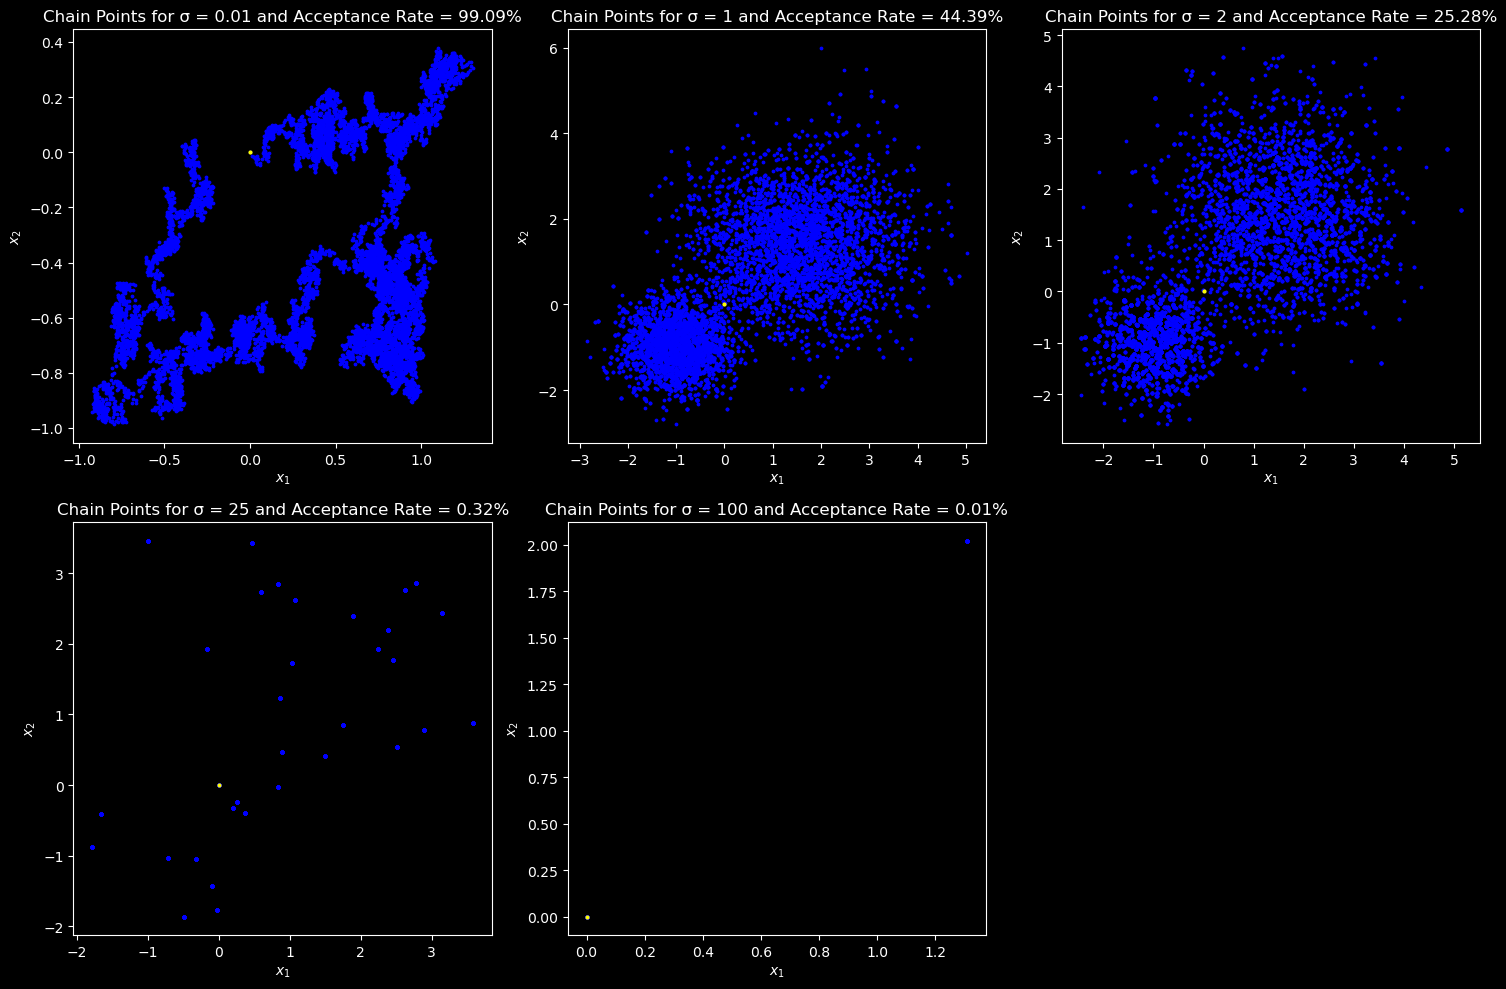

In [19]:
#We write down the code block given to us in the question for the Bimodal Distribution.
def pdf_bimodal(x):
    """Bimodal pdf"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/((2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2).sum()/sigma1**2)  +  0.5/((2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2).sum()/sigma2**2)
    return pdf

#We define the Chain Point numbers as 10000.
N = 10000

#We also define a range of Sigmas that are given in the question.
#Note that sigmas here represent the Proposal Width.
sigmas = [0.01, 1, 2, 25, 100]

#We define an initial point.
#We can choose 0,0 as a start.
x_initial = [0, 0]

#We also define a figure to show our plots together.
plt.figure(figsize = (15, 10))

#Now we are going to loop over the sigma values to find and print the chain points alongside acceptance rates.
for i, sigma in enumerate(sigmas):
    #We get the Chain Points and Acceptance Rate.
    chain_points, acceptance_rate = MetropolisHastings(pdf_bimodal, N, x_initial, sigma)

    #We print the Chain Points and Acceptance Rates.
    print(50 * "-")
    print(f"For σ = {round(sigma, 2)}:")
    print(50 * "-")
    print(f"Chain Points: {chain_points}")
    print(50 * "-")
    print(f"Acceptance Rate: {round(acceptance_rate * 100, 2)}%")
    print(50 * "-")

    #We also plot the Chain Points for both x1 and x2 as follows.
    plt.subplot(2, 3, i+1)
    plt.scatter(chain_points[ : , 0], chain_points[ : , 1], color = "blue", s = 3)
    plt.scatter(0, 0, color = "yellow", s = 4)
    plt.title(f"Chain Points for σ = {round(sigma, 2)} and Acceptance Rate = {round(acceptance_rate * 100, 2)}%")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

plt.style.use(["dark_background"])
plt.tight_layout()
plt.show()

*Based on the acceptance rate and visual inspection of the result, argue what parameters work here best.*

*What are the problems with too low or too high values of $\sigma$?* 

* First of all we should note that the **Initial Point for the random walk has been denoted with yellow color in the plots above!**

* The value of $\sigma$ i.e. the Variance:
    * **Represents how much of the parameter space can be explored by our current state!**
    * **If $\sigma$ is too low:**
        * ***The chain will only explore one of the modes.***
        * ***So it means that it will constantly move to a new state but it won't explore the parameter space much!***
        * That's why in the first plot we see that the points are very close to one another like they are forming a path!
        * Also one thing to nore is that **compared to other plots, it explores the least of the parameter space and is one sided!** (It only explores the negative or the positive parameter space on $x_2$ direction!)
        * ***The True Distribution/Bimodal Distribution cannot be recovered from our samples with very low $\sigma$ values!***
    * **If $\sigma$ is too high:**
        * ***The chain will be very "sticky".***
        * ***It will stay in the same state for a long time.***
        * ***So it means that it won't move to a new state easily (hence the less points on the plots) but it will explore more of the parameter space!***
        * That's why compared to the other plots, the last two plots explore much more of the $x_1$ and $x_2$ directions compared to the first 3 plots!
        * ***But the True Distribution/Bimodal Distribution cannot be recovered from our samples with very high $\sigma$ values!***

* **We can see that as $\sigma$ goes down:**
    * **Acceptance Rate goes up!**
    * **Which means that for low $\sigma$ values, moving onto a new state from our current state is very likely (close to $\% 100$)!**
    * **However, for high $\sigma$ values, we see that our current state will most likely be our next state as well since the acceptance rate is so low that moving to a new state is very unlikely ($\%0 - \%0.05$ possibility of moving to a new state)!**

* **So we need an Optimal $\sigma$ value!**
* **That's why in the second and third plot we can actually recover the Bimodal Distribution!**

*Also discuss what happens when you start with initial values far away from the optimum. This initial phase is called "burn in phase".*

* **Burn - In Phase:**
    * Let's assume that our initial values are far away from the optimum.
    * **The initial portion of the Chain where the algorithm is converging to the Target/True Distribution!**
    * During this phase, **the samples may not accurately represent the True Distribution!**

* **The Burn - In Phase:**
    * Allows the Chain to reach a **state where it has coverged to the Target/True Distribution!**
    * **Discards the Early Samples that might be influenced by the choice of Initial values!**

* Now we can check how Burn - In Phase looks by using our code we wrote previously by only chaning the x_initial!

--------------------------------------------------
For σ = 0.01:
--------------------------------------------------
Chain Points: [[20.         20.        ]
 [19.99962832 20.00945247]
 [20.00194737 20.00333821]
 ...
 [12.87341688 13.28013821]
 [12.87302168 13.29444338]
 [12.88481342 13.29902323]]
--------------------------------------------------
Acceptance Rate: 92.45%
--------------------------------------------------
--------------------------------------------------
For σ = 1:
--------------------------------------------------
Chain Points: [[ 2.00000000e+01  2.00000000e+01]
 [ 2.00000000e+01  2.00000000e+01]
 [ 1.87298332e+01  1.85928821e+01]
 ...
 [-3.23544466e-01 -1.69062231e+00]
 [-1.05424255e+00  1.97111904e-02]
 [-5.11926292e-01 -1.04627144e+00]]
--------------------------------------------------
Acceptance Rate: 43.81%
--------------------------------------------------
--------------------------------------------------
For σ = 2:
---------------------------------------------

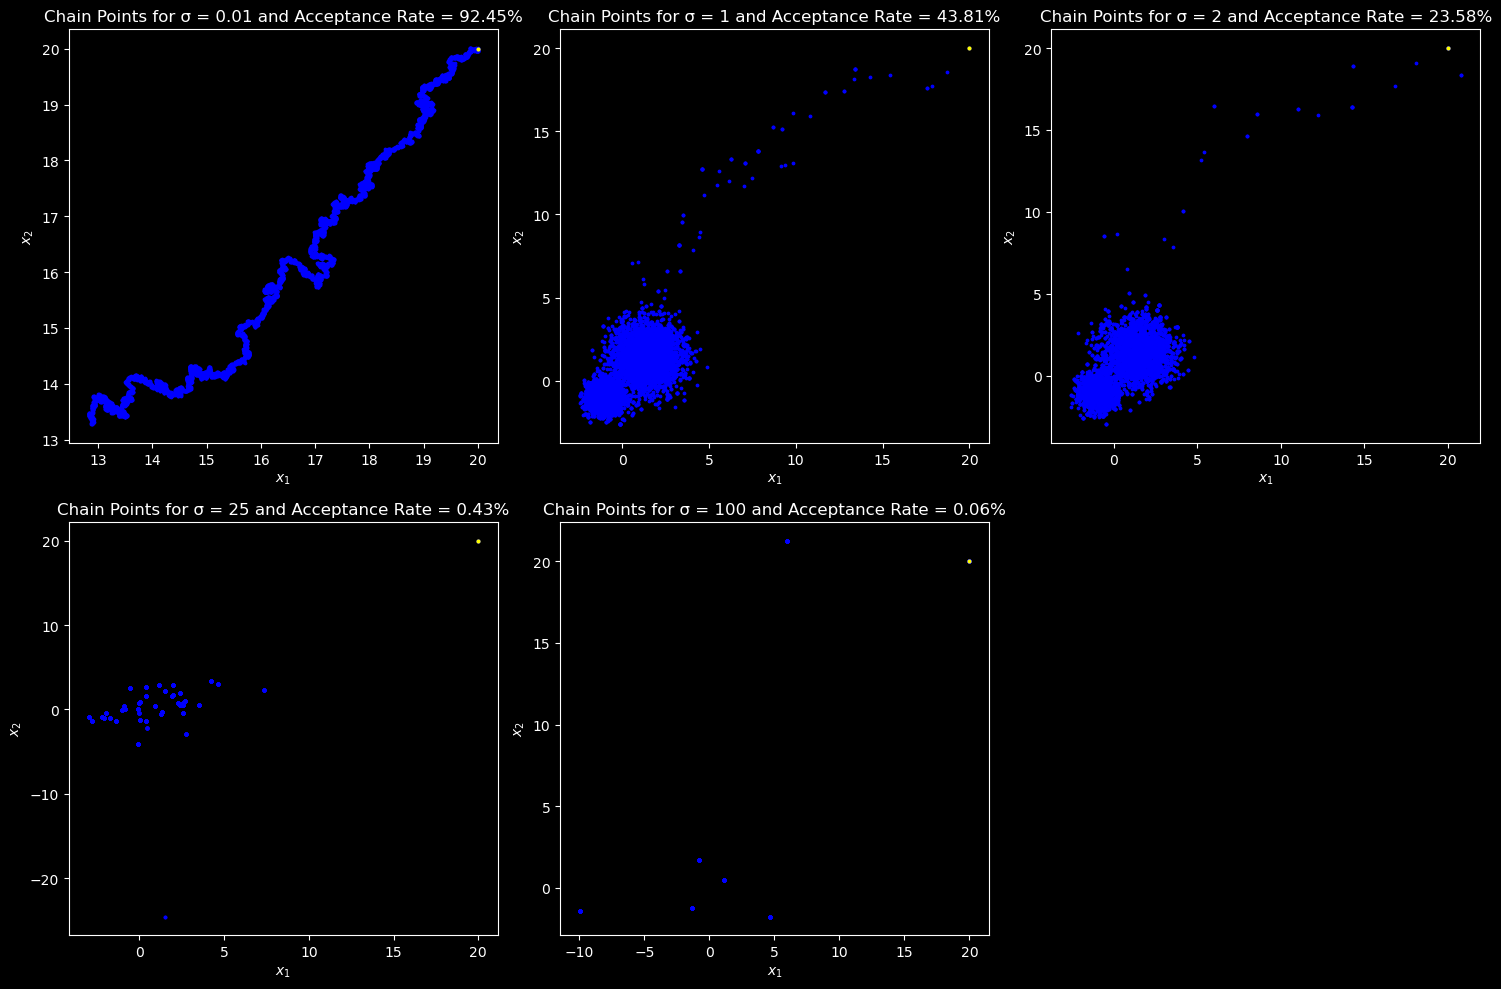

In [20]:
#Now we are going to do the same thing but with x_initial being [20, 20].

#We define a figure to show our plots together.
plt.figure(figsize = (15, 10))

for i, sigma in enumerate(sigmas):
    #We get the Chain Points and Acceptance Rate.
    chain_points, acceptance_rate = MetropolisHastings(pdf_bimodal, N, [20, 20], sigma)

    #We print the Chain Points and Acceptance Rates.
    print(50 * "-")
    print(f"For σ = {round(sigma, 2)}:")
    print(50 * "-")
    print(f"Chain Points: {chain_points}")
    print(50 * "-")
    print(f"Acceptance Rate: {round(acceptance_rate * 100, 2)}%")
    print(50 * "-")

    #We also plot the Chain Points for both x1 and x2 as follows.
    plt.subplot(2, 3, i+1)
    plt.scatter(chain_points[ : , 0], chain_points[ : , 1], color = "blue", s = 3)
    plt.scatter(20, 20, color = "yellow", s = 4)
    plt.title(f"Chain Points for σ = {round(sigma, 2)} and Acceptance Rate = {round(acceptance_rate * 100, 2)}%")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

* We see here that:
    * **In all of the plots, our new states try to make it to the Optimum i.e. the True Distribution!**
    * **Especially in Plot 2 and Plot 3, where $\sigma$ has an Optimal Value, the True Distribution is actually reached!**
        * When $\sigma$ is low, it cannot explore the parameter space well and that's why it never reaches the Optimum!
        * When $\sigma$ is high, it can explore the parameter space hence it reaches the Optimum, however it easily moves away from Optimum and due to that we cannot obtain the True Distribution!

* ***The part where the states make their way to the Optimum is called the "Burn - In Phase"!!!***

3. Compare your results with the true distribution using 1-dim histograms (both in $x_1$ and $x_2$ direction) (3 points)

- Discuss qualitatively whether the true distribution can be recovered for reasonable values of $\sigma$.
- Again, what happens if $\sigma$ is too large or too small?  Is what you see supporting your observations in the previous question?
- Define a function to generate the one dimensional highest posterior density intervals (HPDI) for both parameters at a certain credible level of a given probability density function. Then, calculate the HPDI for the given bimodal distribution at a $68.5\%$ credible level and plot your results.

Note: you have to write your own marginal distributions for `pdf_bimodal`, projected either on `x1` or on `x2` (do these two marginals differ in our case?).

Hints: use `plt.hist` with 100 bins and `density = True`

### Answer:

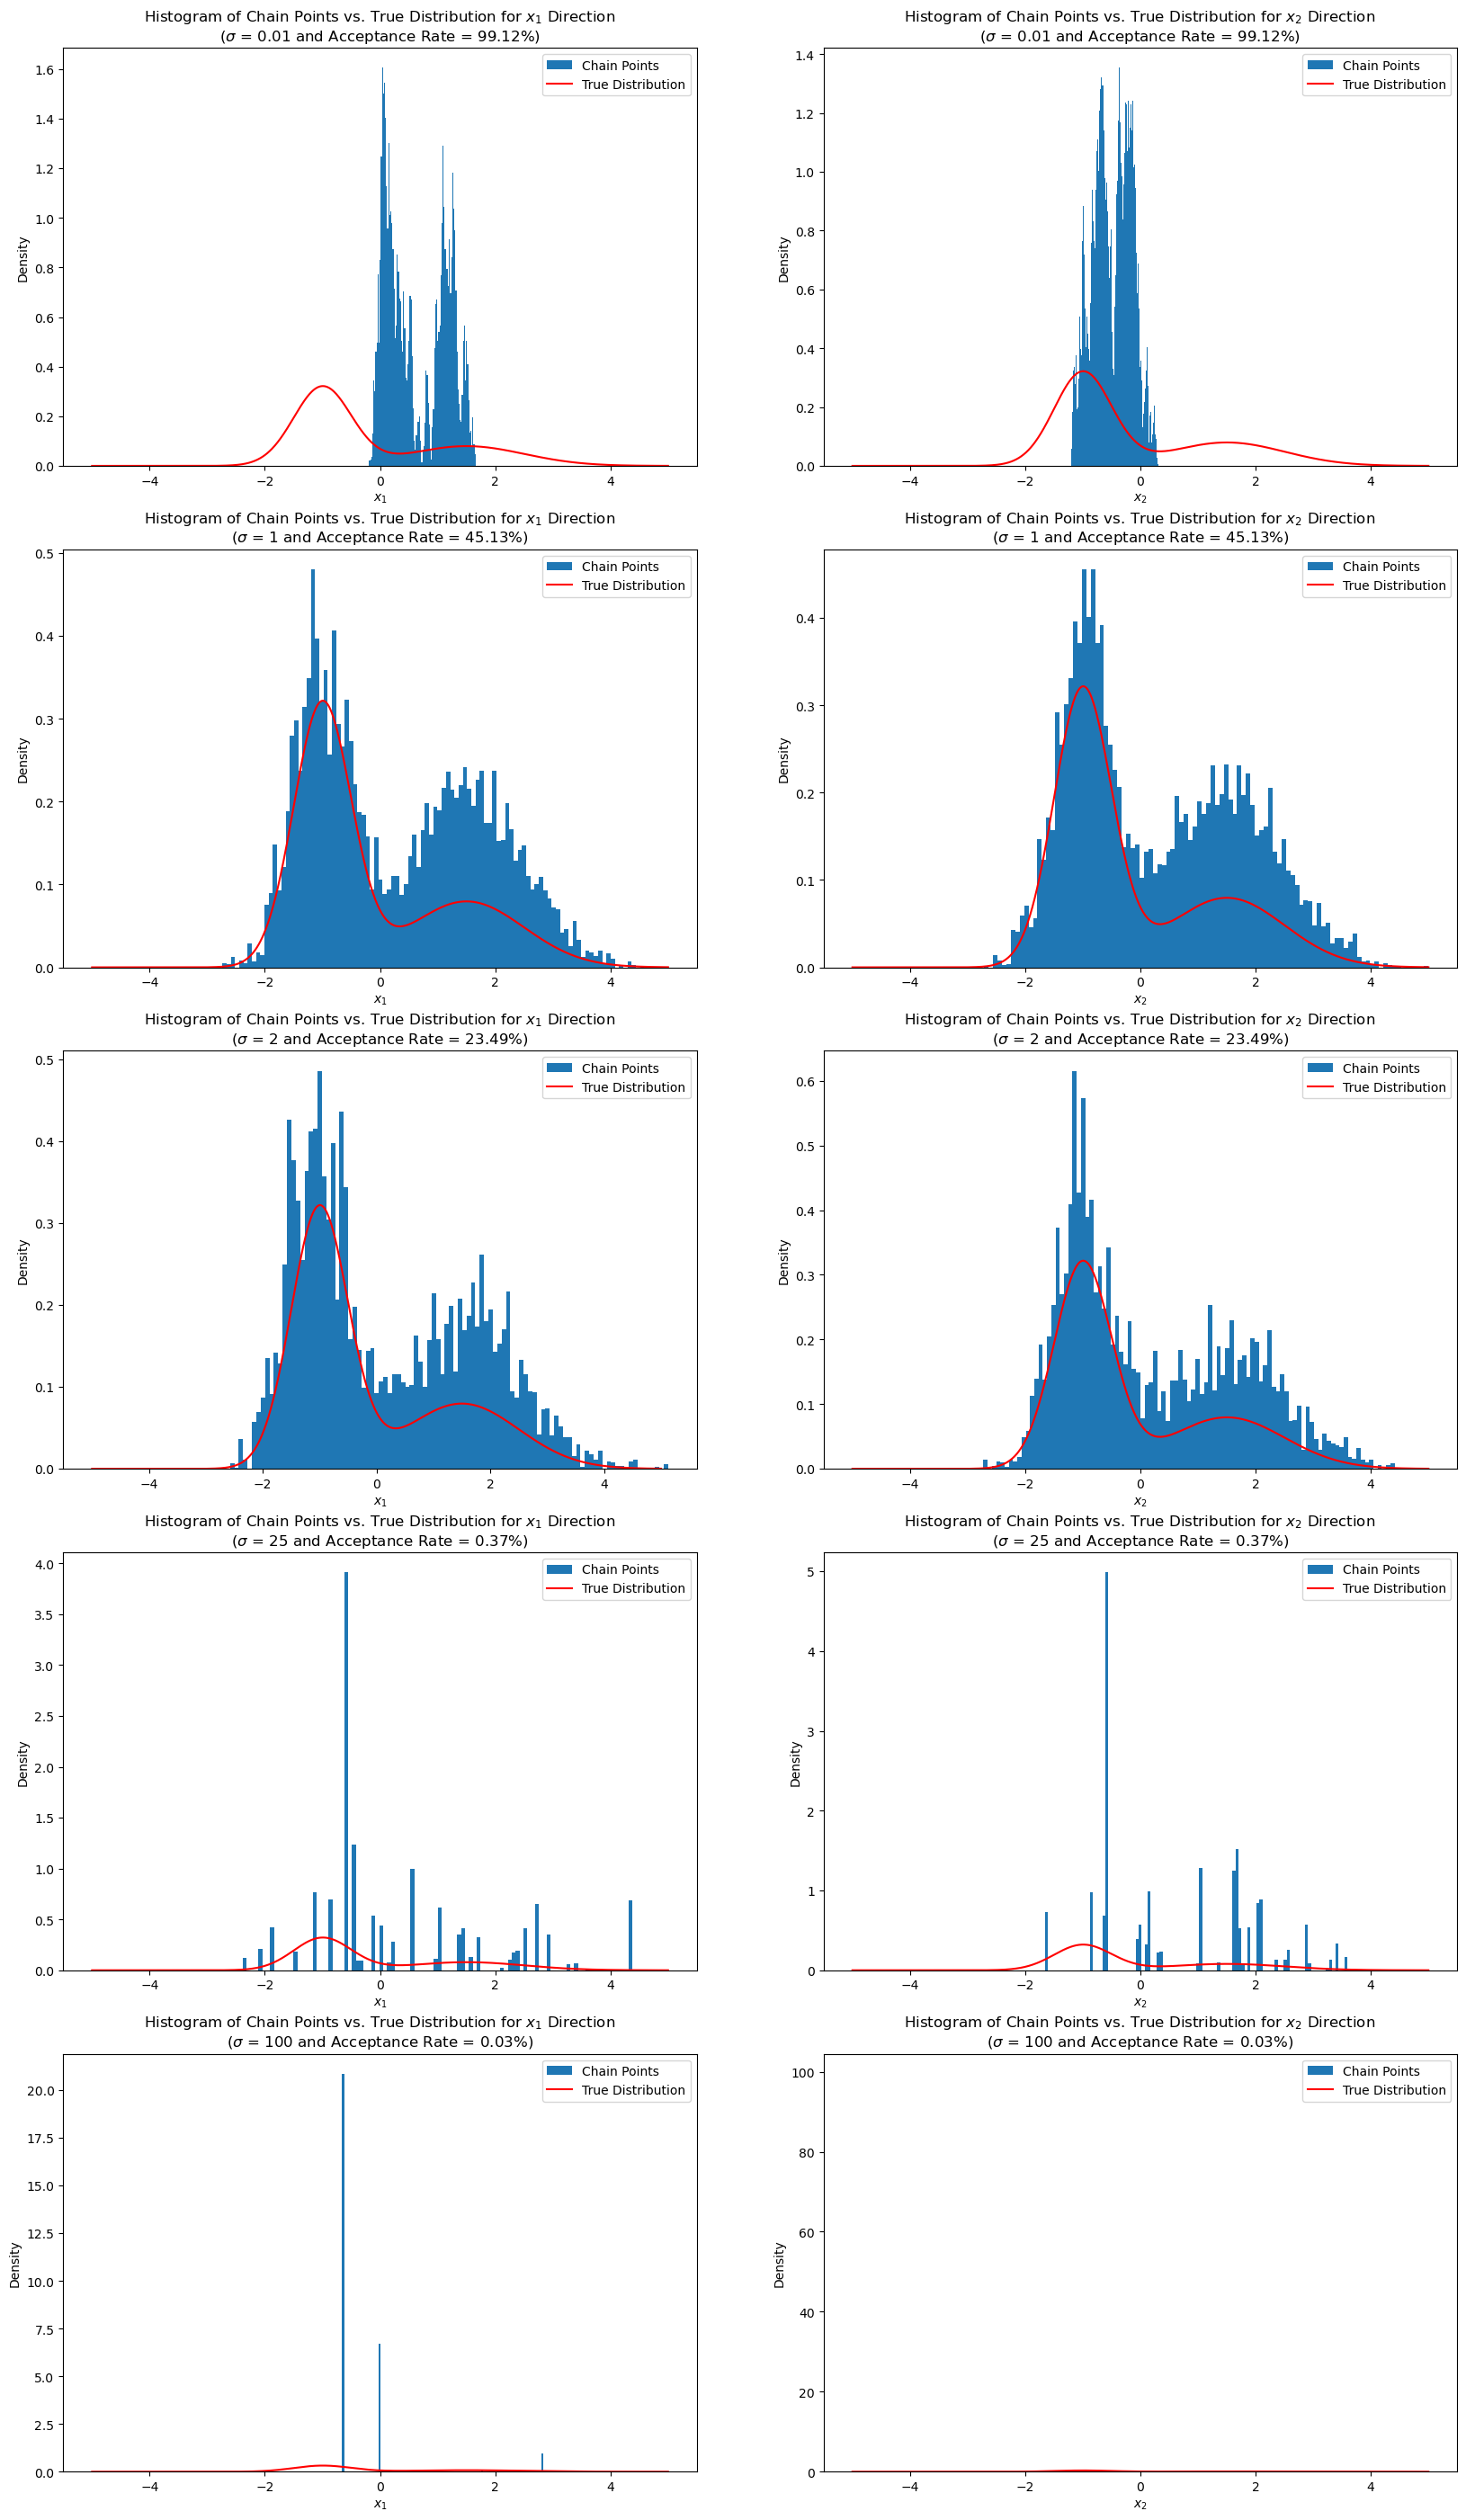

In [22]:
#We now need to define the Marginal PDFs for both x1 and x2.
#For this we basically use the pdf formula and sigmas in pdf_bimodal function.
#As a remainder, we write down the pdf_bimodal function once again.
def pdf_bimodal(x):
    """Bimodal pdf"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/((2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2).sum()/sigma1**2)  +  0.5/((2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2).sum()/sigma2**2)
    return pdf

#Now to define the Marginal PDFs...
#It is literally the same as pdf_bimodal except one difference.
#We don't take the .sum() because this time we only focus on values along a single axis, where on the
#other function we focused on both dimensions!
def marginal_pdf_x1(x):
    """Marginal pdf for x1"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/((2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2)/sigma1**2) + 0.5/((2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2)/sigma2**2)
    return pdf

def marginal_pdf_x2(x):
    """Marginal pdf for x2"""
    sigma1 = 1.0
    sigma2 = 0.5
    pdf = 0.5/((2*np.pi*sigma1**2))*np.exp(-0.5*((x-1.5)**2)/sigma1**2) + 0.5/((2*np.pi*sigma2**2))*np.exp(-0.5*((x+1.0)**2)/sigma2**2)
    return pdf

#Now we once again define a figure to get our plots.
plt.figure(figsize = (20, 35))

#We also define x values for the Marginal PDFs we have defined.
x_values_marginal = np.linspace(-5, 5, 1000)

#We again need to go over the sigma values to see the difference for different sigma values.
#For this we define the following loop.
for i, sigma in enumerate(sigmas):
    #We get the Chain Points and Acceptance Rate.
    chain_points, acceptance_rate = MetropolisHastings(pdf_bimodal, N, x_initial, sigma)
    
    #We first plot the Chain Points for x1 against the Theoretical Marginal PDF of x1.
    plt.subplot(5, 2, 2 * i + 1)
    x1_histogram, _, _ = plt.hist(chain_points[: , 0], bins = 100, density = "True", label = "Chain Points")
    plt.plot(x_values_marginal, marginal_pdf_x1(x_values_marginal), color = "red", label = "True Distribution")
    plt.title(f"Histogram of Chain Points vs. True Distribution for $x_1$ Direction \n($\sigma$ = {round(sigma, 2)} and Acceptance Rate = {round(acceptance_rate * 100, 2)}%)")
    plt.xlabel("$x_1$")
    plt.ylabel("Density")
    plt.legend()
    
    plt.subplot(5, 2, 2 * i + 2)
    x2_histogram, _, _= plt.hist(chain_points[: , 1], bins = 100, density = "True", label = "Chain Points")
    plt.plot(x_values_marginal, marginal_pdf_x2(x_values_marginal), color = "red", label = "True Distribution")
    plt.title(f"Histogram of Chain Points vs. True Distribution for $x_2$ Direction \n($\sigma$ = {round(sigma, 2)} and Acceptance Rate = {round(acceptance_rate * 100, 2)}%)")
    plt.xlabel("$x_2$")
    plt.ylabel("Density")
    plt.legend()

plt.style.use(("default"))

*Discuss qualitatively whether the true distribution can be recovered for reasonable values of $\sigma$.*

* We can say the same things we have said on the previous question.
* In summary we can say the following:
    * **If $\sigma$ is too low:**
        * ***The True Distribution/Bimodal Distribution cannot be recovered from our samples with very low $\sigma$ values!***
    * **If $\sigma$ is too high:**
        * ***The True Distribution/Bimodal Distribution cannot be recovered from our samples with very high $\sigma$ values!***
    * **If $\sigma$ is equal to an optimal value:**
        * ***The True Distribution/Bimodal Distribution can be recovered from our samples!***

*Again, what happens if $\sigma$ is too large or too small?  Is what you see supporting your observations in the previous question?*

* From our new plots we observe the following:
    * **If $\sigma$ is too low:**
        * ***Our True Distribution do not match with the Chain Points i.e. Samples for both $x_1$ and $x_2$ directions!***
        * Can be seen on Plot 1. ($\sigma = 0.01$)
    * **If $\sigma$ is equal to an optimal value:**
        * ***The True Distribution/Bimodal Distribution does match with the Chain Points i.e. Samples for both $x_1$ and $x_2$ directions!***
        * Can be seen on Plot 2 and Plot 3. ($\sigma = 1$ and $\sigma = 2$)
    * **If $\sigma$ is too high:**
        * ***Our True Distribution do not match with the Chain Points i.e. Samples for both $x_1$ and $x_2$ directions!***
        * Can be seen on Plot 4 and Plot 5. ($\sigma = 25$ and $\sigma = 100$)

* One may realise that the **marginal PDFs are the same!**
* **Remember the derivation from last week's question.**
* * **As for the other Marginal Distributions for $\mu_2$ and $\mu_3$:**
    * **They are the same as $\mu_1$!!**
    * **Due to this, the Marginal Distributions will be similar since the ONLY difference will be on the Covariance Matrix i.e. $\Sigma$!**
    * **Also due to no rotation or scaling involved, the Marginal Distributions along $x$ and $y$ axes are unaffected by the change in the Covariance matrix!**
    * **So we expect the Marginal Distributions to look the same!!!**

* **For that reason, the Marginal Distributions are both the same!**
* For more information and mathematical derivation, check the previous Exercise Sheet.

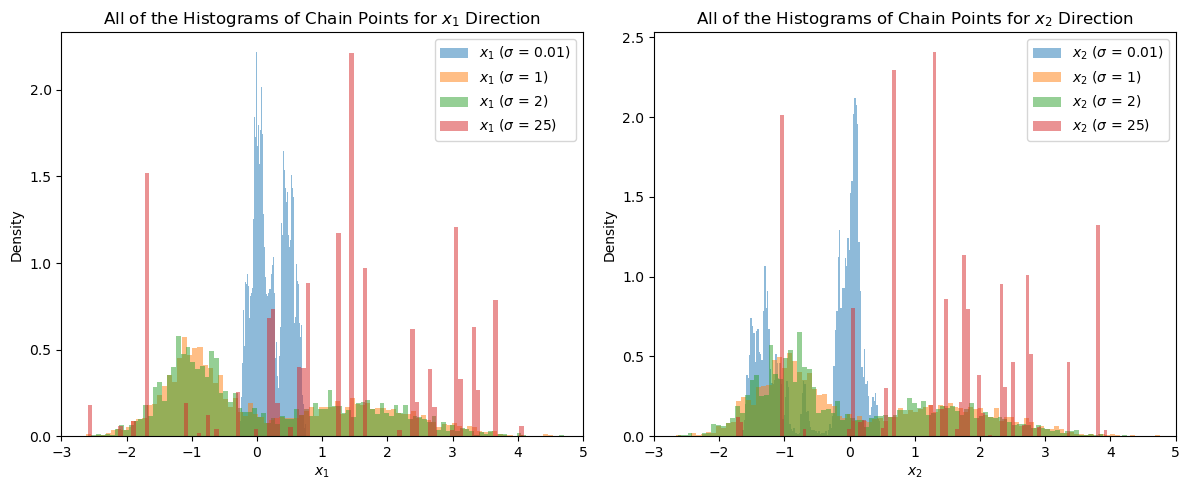

In [23]:
#Now we additionally plot all the histograms of x1 and x2 together.
#For this, we once again define a figure to get our plots.
plt.figure(figsize = (12, 5))

#Now we again loop over sigma values.
for i, sigma in enumerate(sigmas):
    #We will not plot sigma = 100 since it affects the histograms drastically with the high density counts!
    #We want to show the differences on histograms depending on the sigma values.
    if i == 4:
        continue
    
    #We get the Chain Points and Acceptance Rate.
    chain_points, acceptance_rate = MetropolisHastings(pdf_bimodal, N, x_initial, sigma)
    
    plt.subplot(1, 2, 1)
    plt.hist(chain_points[: , 0], bins = 100, density = "True", alpha = 0.5, label = f"$x_1$ ($\sigma$ = {round(sigma, 2)})")
    plt.title(f"All of the Histograms of Chain Points for $x_1$ Direction")
    plt.xlabel("$x_1$")
    plt.ylabel("Density")
    plt.xlim(-3, 5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(chain_points[: , 1], bins = 100, density = "True", alpha = 0.5, label = f"$x_2$ ($\sigma$ = {round(sigma, 2)})")
    plt.title(f"All of the Histograms of Chain Points for $x_2$ Direction")
    plt.xlabel("$x_2$")
    plt.ylabel("Density")
    plt.xlim(-3, 5)
    plt.legend()

plt.tight_layout()
plt.show()

* Even in here we see the **Bimodal Distribution** only for $\sigma = 1$ and $\sigma = 2$!
* The other $\sigma$ values **do not show anything remotely close to the True Bimodal Distribution!**

*Define a function to generate the one dimensional highest posterior density intervals (HPDI) for both parameters at a certain credible level of a given probability density function. Then, calculate the HPDI for the given bimodal distribution at a $68.5\%$ credible level and plot your results.*

* For this, let's remember what we have discussed previously from the reading material.
* **Highest Posterior Density (HPD):**
    * Defined as ***the set of most probable points that in total consitute $100(1-\alpha)\%$ of the Probability Mass!***

* **To calculate HDIs in 1 Dimension:**
    * 1-) Search over points such that **the interval contains %95 of the Mass and has minimal width!**
    * 2-) This can be done by **1-D Numerical Optimization if we know the inverse CDF of the distribution!**
    * 3-) We can also do this by **searching over the sorted Data Points if we have a bag of Samples!**

* Now we apply this to our code.

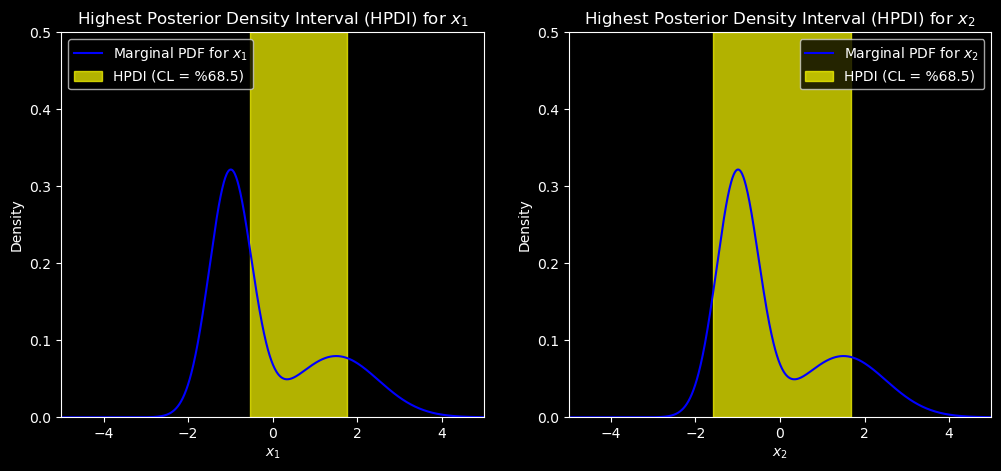

In [11]:
#To Calculate HPDI for both parameters, it is best to define a function for it.
def HPDI(samples, credible_level):
    """Takes the samples and Credible Level. Returns the upper and lower bound 
    of the Highest Probability Density Interval (HPDI).
    
    Input:
    ----------------------------------------------------------------------------
    samples: Samples we have from the PDF (x values).
    credible_level: Credible Value that can be between 0 and 1.
    
    Output:
    ----------------------------------------------------------------------------
    HPDI: Array Containing the Upper and Lower Bound of the HPDI.
    
    """

    #We first sort the samples we have.
    sorted_samples = np.sort(samples)

    #Then we check the number of samples we have.
    n = len(samples)

    #We use the number of samples to calculate the percentage of all samples. (?)
    n_samples_in_interval = int(credible_level * n)
    min_interval_width = np.inf

    #We define HPDI as a None type to later on store the Upper and Lower Bound of HPDI.
    HPDI = None

    #We use the following loop to find the HPDI's upper and lower bounds.
    for i in range(n - n_samples_in_interval):
        interval_width = sorted_samples[i + n_samples_in_interval] - sorted_samples[i]
        if interval_width < min_interval_width:
            min_interval_width = interval_width
            HPDI = (sorted_samples[i], sorted_samples[i + n_samples_in_interval])
    
    return HPDI

#Our credible level is given as %68.5 so we define it on our code as follows.
credible_level = 0.685

#Now we calculate the HPDI for both x1 and x2 by using our newly defined function.
HPDI_x1 = HPDI(chain_points[ : , 0], credible_level)
HPDI_x2 = HPDI(chain_points[ : , 1], credible_level)

#Now we plot our results.
plt.figure(figsize = (12, 5))

#For x1 direction:
plt.subplot(1, 2, 1)
plt.plot(x_values_marginal, marginal_pdf_x1(x_values_marginal), color = "blue", label = "Marginal PDF for $x_1$")
plt.fill_betweenx(y = [0, 0.5], x1 = HPDI_x1[0], x2 = HPDI_x1[1], color = "yellow", alpha = 0.7,
                  label = f"HPDI (CL = %{100 * credible_level})")
plt.title("Highest Posterior Density Interval (HPDI) for $x_1$")
plt.xlabel("$x_1$")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.ylim(0.0, 0.5)
plt.legend(loc = "upper left")

#For x2 direction:
plt.subplot(1, 2, 2)
plt.plot(x_values_marginal, marginal_pdf_x2(x_values_marginal), color = "blue", label = "Marginal PDF for $x_2$")
plt.fill_betweenx(y = [0, 0.5], x1 = HPDI_x2[0], x2 = HPDI_x2[1], color = "yellow", alpha = 0.7,
                  label = f"HPDI (CL = %{100 * credible_level})")
plt.title("Highest Posterior Density Interval (HPDI) for $x_2$")
plt.xlabel("$x_2$")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.ylim(0.0, 0.5)
plt.legend(loc = "upper right")

plt.style.use(["dark_background"])
plt.show()

Usage of AI: *Used to check the structure of the Metropolis Hastings Algorithm code in 3.2.1. Also used to structure and optimize the code in 3.2.2. Used on most of the code structure in 3.2.3., alongside the optimization of the code for loops. Also used on the HPDI function, basically the function is copied completely from AI.*

### 3.3 Conditional independence and reparametrization (4 points)

*Topics: Independence and Conditional independence*

**Reading material: Murphy 10.1.2**

1. Reparametrization (2 points). In class we introduced the KL divergence
$$
D_{KL}(q \mid p) \equiv \int dx\; q(x) \ln\frac {q(x)}{p(x)}
$$
Show that it is reparametrization invariant, if we replace $x$ with another random variable $y = f(x)$, where $f(x)$ is strictly monotonic and differentiable.  Start by quoting $q(y)$ and $p(y)$ in terms of $q(x)$ and $p(x)$.

### Answer:

* The change of variables can be done by the following formula.

$$P(y) = P(x)\left|\frac{dx}{dy}\right|$$

* Using this formula, we can replace $x$ with random variable $y = f(x)$.
* We first quote $q(y)$ in terms of $q(x)$.

$$ q(y) = q(f(x)) $$
<h5><center> From here we get an expression for $q(y)$.</h5>
$$ q(y) = q(x) \left|\frac{dx}{dy}\right|$$
<h5><center> From here we also get an expression for $q(x)$ as well.</h5>
$$ q(x) = q(y) \left|\frac{dy}{dx}\right|$$

* We do the same by quoting $p(y)$ in terms of $p(x)$.

$$ p(y) = p(f(x)) $$
<h5><center> From here we get an expression for $p(y)$.</h5>
$$ p(y) = p(x) \left|\frac{dx}{dy}\right|$$
<h5><center> From here we also get an expression for $p(x)$ as well.</h5>
$$ p(x) = p(y) \left|\frac{dy}{dx}\right|$$

* Now we put these expressions into the $D_{KL}(q \mid p)$ formula as follows.

$$D_{KL}(q \mid p) \equiv \int dx\; q(x) \ln\frac {q(x)}{p(x)}$$
<h5><center> We put $q(x)$ expression into the formula first. </h5>
$$D_{KL}(q \mid p) \equiv \int dx \left|\frac{dy}{dx}\right|\; q(y) \ln\frac {q(x)}{p(x)}$$
$$D_{KL}(q \mid p) \equiv \int dy\; q(y) \ln\frac {q(y)}{p(y)}$$
<h5><center> Then, we put $q(y)$ and $p(y)$ expressions into the formula. </h5>
$$D_{KL}(q \mid p) \equiv \int dy\; q(x) \left|\frac{dx}{dy}\right| \ln \left( \frac {q(x) \left|\frac{dx}{dy}\right|}{p(x) \left|\frac{dx}{dy}\right|} \right)$$
<h5><center> The derivatives cancel out in $\ln$ but also in the left hand side ($dy$ terms) and we are left with the following formula. </h5>
$$D_{KL}(q \mid p) \equiv \int dx\; q(x) \ln \left( \frac {q(x)}{p(x)} \right)$$

* **So the KL Divergence is reparametrization invariant!**

2. Conditional independence (2 points). Consider the graphical model defined by $p(x, y, z) = p(x \mid y) p(y \mid z) p(z)$. Show explicitly, by using the relevant definitions, that
- $x$ and $z$ are conditionally independent given $y$
- $z$ and $x$ are conditionally independent given $y$

### Answer:

* We are talking about **Conditionally** independence.
* For this, we first need to remember the Conditional Probability formula which is given by the following.

$$P(x|y) = \frac{P(x,y)}{P(y)}$$

* We first show that $x$ and $z$ are conditionally independent given $y$!
* For this we apply the formula above which gives us the following formula.

$$P(x,z|y) = \frac{P(x,z,y)}{P(y)}$$

* Recall that the Graphical Model is given as follows.

$$P(x, y, z) = P(x|y) P(y|z) P(z)$$

* We put this into our formula and get the following.

$$P(x,z|y) = \frac{P(x|y) P(y|z) P(z)}{P(y)}$$

* The probability of $y$ does not depend on $z$!
* For that reason, $P(y|z)$ and $P(y)$ cancel out.

$$P(x,z|y) = P(x|y)P(z)$$

* We also know that $z$ is not dependent on $y$.
* For that reason, we can say that $P(z) = P(z|y)$.

$$P(x,z|y) = P(x|y)P(z) = P(x|y)P(z|y)$$

* **This shows us that the $x$ and $z$ are conditionally independent given $y$!**

* Now we do the same for $z$ and $x$ are conditionally independent given $y$.
* For this we apply the first formula we have given which gives us the following formula.

$$P(z,x|y) = \frac{P(z,x,y)}{P(y)}$$
<h5><center> We write the Graphical Model into the formula.</h5>
$$P(z,x|y) = \frac{P(x|y) P(y|z) P(z)}{P(y)}$$
<h5><center> Probablity of $y$ does not depend $z$ so $P(y|z)$ and $P(y)$ cancel out.</h5>
$$P(z,x|y) = P(x|y)P(z)$$
<h5><center> $z$ is not dependent on $y$ so $z$ so $P(z) = P(z|y)$.</h5>
$$P(z,x|y) = P(x|y)P(z) = P(x|y)P(z|y)$$

* **This shows us that the $z$ and $x$ are conditionally independent given $y$!**

Usage of AI: *Used for understanding some of the concepts & steps. Also got help from John Lopez.*

## Chapter 4: Linear regression (10 points)


### 4.1  Regularized Regression (10 points)


In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
#plt.style.use(['dark_background']) # if using dark background, easier to see the plots

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

*Topics: Regularized regression*

**Reading Material: Ref: Murphy 7.5**

1. (2 points) $$\\ $$
Write a method `gen_sine(N)` that generates toy data like in the figure below. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from (0,1), and the elements $t_i$ of $\bt$ are distributed according to
$$t_i \sim \mathcal{N}(\mu_i, \sigma^2),$$
with the mean given by $\mu_i = \sin( 2 \pi x_i)$ and the standard deviation $\sigma=0.25$. Here $x_i$ is the $i$-th element of $\bf{x}$. You can make use of `np.random.normal()`.

Test your function by generating a plot similar to the one below:

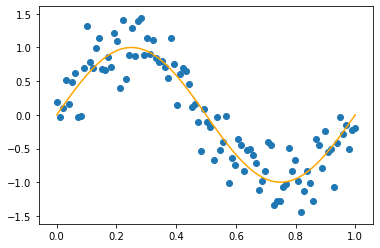

### Answer:

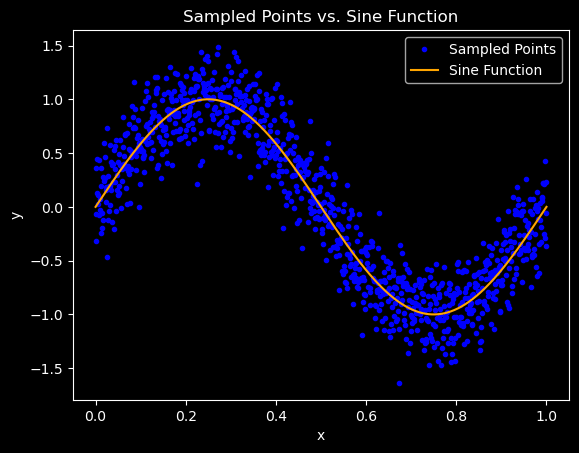

In [13]:
def gen_sine(n):
    """Takes the amount of samples the user wants the produce (n) and returns two
    vectors containing x values (xi) and the y values (ti) individually.
    
    Input:
    ----------------------------------------------------------------------------
    n: Amount of samples that will be generated.
    
    Output:
    ----------------------------------------------------------------------------
    x_vector: 1 x N Dimensional Vector that contains the x values.
    t_vector: 1 x N Dimensional Vector that contains the t values. (y values)
    
    """
    #We first define the x vector.
    #Note that x is a vector that contains evenly spaced values from 0 to 1 with N dimension.
    x_vector = np.linspace(0, 1, n)

    #We then define the t vector.
    #For this, we first define a vector that will store the ti values.
    t_vector = np.zeros((len(x_vector)))
    
    #It's elements (ti) are Normally Distributed.
    #The Normal Distribution we will sample from has sigma = 0.25.
    #But the Distribution's mean changes depending on the x element we are on.
    #For that reason: 
        #We define a loop that will go over elements of the x vector.
        #It will find the mean of the Normal Distribution we will sample from by using the x we are on.
        #We use the mean we have calculated with standard deviation we have to define the Normal Distribution.
        #We sample from that Normal Distribution which gives us the ti element of the t vector.

    #We define the loop that will go over elements of x vector.
    for i, xi in enumerate(x_vector):
        #Standard Deviation stays the same.
        sigma = 0.25

        #Mean changes depending on the xi value we have.
        mean = np.sin(2 * np.pi * xi)

        #We sample from the normal distribution with the mean we calculated and sigma we already have.
        ti = np.random.normal(mean, sigma, 1)[0]

        #We add the ti element to our t vector.
        t_vector[i] = ti
    
    return x_vector, t_vector

#Now we test out our function as follows.
x_vector, t_vector = gen_sine(1000)

#We now plot the vectors together alongside the sine function to show our points sample from sine.
plt.plot(x_vector, t_vector, ".", color = "blue", label = "Sampled Points")
plt.plot(x_vector, np.sin(2 * np.pi * x_vector), color = "orange", label = "Sine Function")
plt.title("Sampled Points vs. Sine Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "upper right")
plt.style.use(["dark_background"])
#plt.style.use(("default"))
plt.show()

2. (2 points) $$\\ $$  Write a method that finds the regularized $M$-th order polynomial for some fixed dataset $\bx$. Your method should include the regularizer weight $\lambda$ as a parameter and return a vector $\bw$ with the maximum-likelihood parameter estimates.

### Answer:

* For this part, we will use a **Design Matrix**.
* **Design Matrix:**
    * **Each row of it corresponds to a datapoint in our dataset!**
    * **Each column of it corresponds to a basis function or feature transformation of the input variables!**

* **In our case the Design Matrix is:**
    * **Each row is our $x$ values from the $x$ vector!**
    * **Each column is our different polynomial degrees for $x$ values!**
        * $x^0$ -> Constant Term!
        * $x^M$ -> Highest Degree term in the Polynomial!

$$
\bPhi = \begin{bmatrix}
1 & x_1 & x_1^2 & \ldots & x_1^M \\
1 & x_2 & x_2^2 & \ldots & x_2^M \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_N & x_N^2 & \ldots & x_N^M \\
\end{bmatrix}
$$


* Our goal is to find the **Maximum Likelihood Parameter Estimates** which is given with $\bw$!
* For this we can use the following formula:

$$ \bw_{ML} = (\bPhi^{T}\bPhi)^{-1}\bPhi^{T}t $$

<h5><center>$\bPhi$ represents the Design Matrix!</h5>
<h5><center>$T$ represents the Transpose of the matrices!</h5>
<h5><center>$-1$ represents the inverse of the matrices!</h5>
<h5><center>$t$ represents t vector!</h5>

In [14]:
#For this part we need to import Inverse from the linalg library of numpy.
from numpy.linalg import inv

#Now we define the following function to make a Polynomial fit.
def fit_polynomial_reg(x_vector, t_vector, M, lambda_value):
    """Takes the x vector and t vector we generated with gen_sine(n), also takes
    M and lambda_value given by the user. Calculates the Design Matrix and then
    returns the Maximum-Likelihood Parameter Estimates.
    
    Input:
    ----------------------------------------------------------------------------
    x_vector: 1 x N Dimensional Vector that contains the x values.
    t_vector: 1 x N Dimensional Vector that contains the t values. (y values)
    M: The degree of Polynomial Fit.
    lambda_value: Regularizer Weight.
    
    Output:
    ----------------------------------------------------------------------------
    w_max_likelihood: Array containing the Maximum Likelihood Parameter Estimates.
    
    """
    
    #We first define our Design Matrix!
    phi = np.array([x_vector ** i for i in range(M + 1)]).T

    #We then compute the Maximum Likelihood Parameter estimates!
    w_max_likelihood = np.dot(np.dot(inv(np.dot(phi.T, phi) + lambda_value * np.identity(M + 1)), phi.T), t_vector)

    return w_max_likelihood

3. (2 point) $$\\ $$  Use your ``` gen_sine``` method to generate 25 datapoints as "training set", and another 25 datapoints as "test set", under the same conditions as before.  Then, fit polynomials of $M \in (0,2,3,9, 20)$ for values $\lambda = 0$ (unregularized case) to your test set. Plot your results, showing the polynomials, the test and the training set simultaneously.

### Answer:

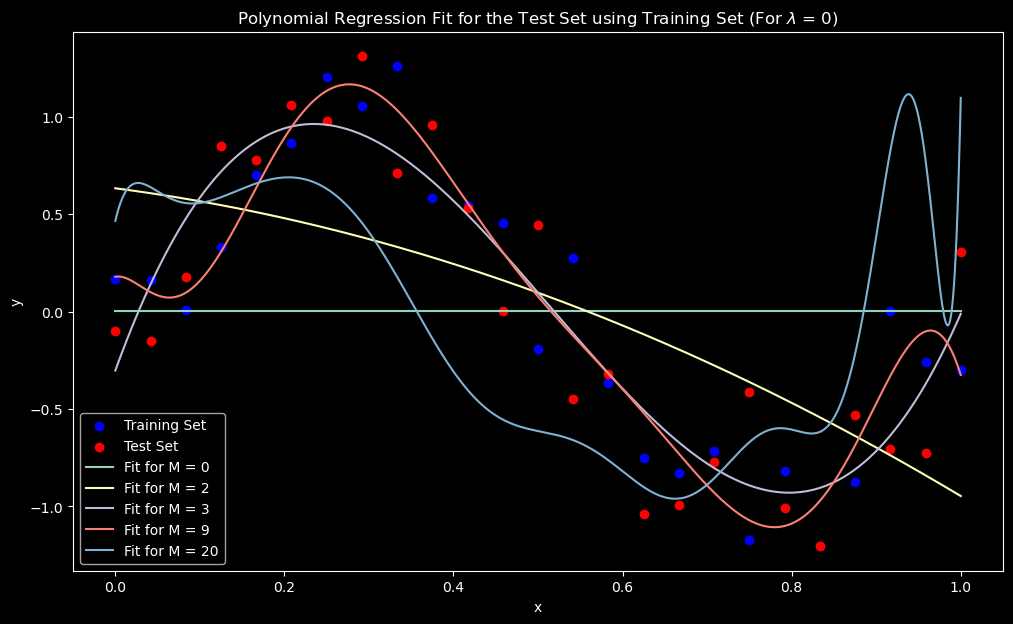

In [15]:
#We first generate our 25 datapoints for Training set and Test set as follows.
x_training, t_training = gen_sine(25)
x_test, t_test = gen_sine(25)

#We now define a list containing the Polynomial degrees as follows.
M_list = [0, 2, 3, 9, 20]

#We also define an x range to define the range of our fit.
x_values = np.linspace(0, 1, 1000)

#Now we plot the Training Set and Test Set together.
plt.figure(figsize = (12, 7))
plt.scatter(x_training, t_training, color = "blue", label = "Training Set")
plt.scatter(x_test, t_test, color = "red", label = "Test Set")

#Now we define a loop where we will go over all the M (Polynomial Degree) values.
for M in M_list:
    #Lambda value is given as zero on the question.
    lambda_value = 0

    #We find the Maximum Likelihood Parameter Estimates by using our function fit_polynomial_reg.
    w = fit_polynomial_reg(x_training, t_training, M, lambda_value)

    #We again calculate the design matrix.
    phi_fit = np.array([x_values ** i for i in range(M + 1)]).T
    
    #We then find the y values i.e. the fit values by using the Design Matrix and Maximum Likelihood Parameter
    #Estimates.
    y_values = np.dot(phi_fit, w)

    #We plot our Fit.
    plt.plot(x_values, y_values, label = f"Fit for M = {M}")

#We also define the labels, title etc. as follows.
plt.title("Polynomial Regression Fit for the Test Set using Training Set (For $\lambda$ = 0)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

4. (2 points)

  For the above fits with $\lambda=0$ (unregularized case) calculate the reduced chi-squared statistics for each $M$ both for the training and the test set.
$$
\chi_\nu^2 = \frac{\chi^2}{\nu},
$$
$$
\chi^2 = \sum_i \frac{(O_i - C_i)^2}{\sigma_i^2}.
$$
Plot the $\chi^2$ values for both training and test set as function of $M$. What do you observe?

### Answer:

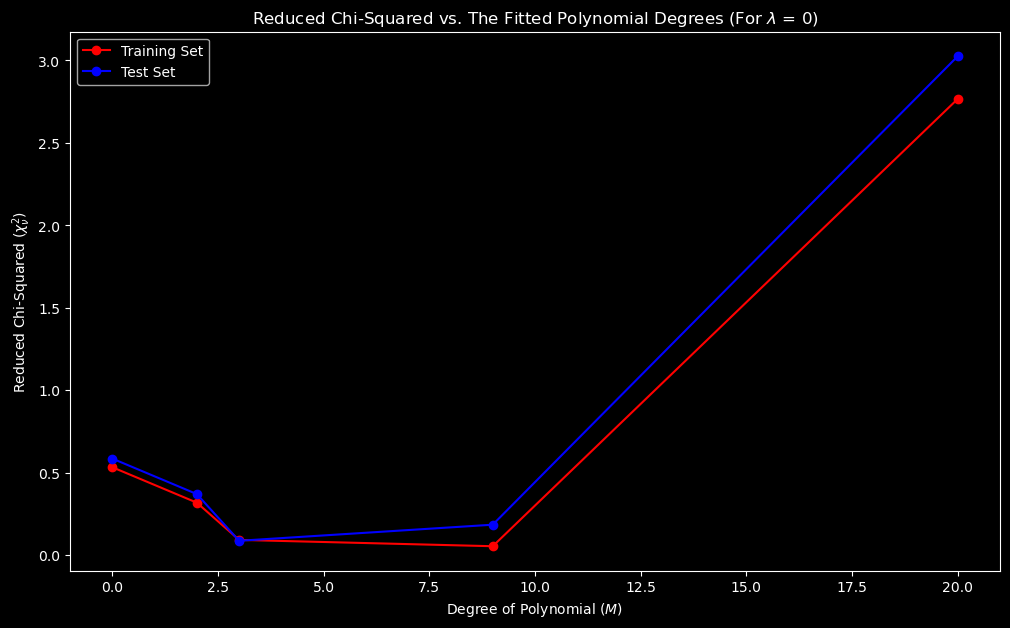

In [16]:
#Just like we did previously, we will define two lists for chi squared: Training and Test
chi_squared_training = []
chi_squared_test = []

#The algorithm we will use is for each M value:
    #1-) Find the w, Design Matrix and Predicted value for the t training set value.
    #2-) Find the difference between the original t training set value and predicted t training set value and 
    #add that to the chi_squared_training list. (Observed - Calculated!)
    #3-) Find the w, Design Matrix and Predicted value for the t test set value.
    #4-)

#We again loop over all the M values i.e. the Polynomial Degrees.
for M in M_list:
    #Lambda value is given as zero on the question.
    lambda_value = 0

    ########################################### t - training set ###########################################
    
    #We find the Maximum Likelihood Parameter Estimates for t training value by using our fit_polynomial_reg
    #function!
    w = fit_polynomial_reg(x_training, t_training, M, lambda_value)

    #We calculate the design matrix for t training value.
    phi_training = np.array([x_training ** i for i in range(M + 1)]).T
    
    #We then find the t training values by using the Design Matrix and Maximum Likelihood Parameter
    #Estimates i.e. Calculated t training values!
    t_training_prediction = np.dot(phi_training, w)

    #We now get the residual between the t_training value and t_training_prediction value.
    #Basically we check the (OBSERVED - CALCULATED)!!!
    residual_t_training = t_training - t_training_prediction

    #We then get the numerator of the Chi Squared for our current training data as follows.
    chi_squared_training.append(np.sum(residual_t_training**2))

    ########################################################################################################
    ############################################## t - test set ############################################

    #Since model parameters are independent of specific dataset used for training or testing once they have
    #been estimated, we don't find model parameters (w) for test set and just use the previous one!!!
    
    #Now we calculate the predicted values for the Test set!
    phi_test = np.array([x_test ** i for i in range(M + 1)]).T

    #We find the t test values by using the Design Matrix and Maximum Likelihood Parameter Estimates i.e. 
    #Calculated t test values!
    t_test_prediction = np.dot(phi_test, w)

    #We now get the residual between the t_training value and t_training_prediction value.
    #Basically we check the (OBSERVED - CALCULATED)!!!
    residual_t_test = t_test - t_test_prediction 

    #We then get the numerator of the Chi Squared for our current training data as follows.
    chi_squared_test.append(np.sum(residual_t_test**2))

    ########################################################################################################

#Now we need to calculate the Number of Degrees of Freedom for each Polynomial Fit.
#For this we do the following.
nu_training = len(x_training) - np.array(M_list) - 1
nu_test = len(x_test) - np.array(M_list) - 1

#Now we calculate the reduced Chi-Squared Values for Training and Test sets by using d.o.f.
#For this, we use the formula given on the question.
chi_squared_reduced_training = np.array(chi_squared_training) / nu_training
chi_squared_reduced_test = np.array(chi_squared_test) / nu_test

#Finally, we plot the Chi-Squared values for Training and Test sets as a function of different M values!
plt.figure(figsize = (12, 7))
plt.plot(M_list, chi_squared_reduced_training, marker = "o", color = "red", label = "Training Set")
plt.plot(M_list, chi_squared_reduced_test, marker = "o", color = "blue", label = "Test Set")
plt.xlabel("Degree of Polynomial ($M$)")
plt.ylabel("Reduced Chi-Squared ($\chi^2_{ν}$)")
plt.title("Reduced Chi-Squared vs. The Fitted Polynomial Degrees (For $\lambda$ = 0)")
plt.legend()
plt.show()

*Plot the $\chi^2$ values for both training and test set as function of $M$. What do you observe?*

* We see that **Lower Values of $M$ i.e. the lower Degree Polynomial Fits** results in larger $\chi^2$. (What we call as **Underfitting**)
* But as we get to the **Higher Values of $M$ i.e. the Higher Degree Polynomial Fits** we get a better (smaller) $\chi^2$ which means that our fit is better compared to the previous fit we have done with less degree polynomial.**
* Note that ***there is an optimal $M$ value i.e. Degree of Polynomial for a small $\chi^2$ which means a good fit!!!***
* We see this on our plot as well!
* As we get to the **Much Higher Values of $M$ i.e. the Higher Degree Polynomial Fits** our $\chi^2$ increases which **means our fits are getting worse!**
    * This is what we call **Overfitting**!

* In summary:
    *  **There is a sweet spot for the Degree of Polynomial we do the fitting with!**
    * **If the degree is lower than the sweet spot, our $\chi^2$ increases!**
    * **If the degree is higher than the sweet spot, our $\chi^2$ increases!**
        * To see this again, we can check the plot before the current plot we are at!

5. (2 point) $$\\ $$  For $M=9$, repeat the previous exercise, but instead of varying $M$ you now vary $\lambda\in (0,10^{-5}, 10^{-3}, 10^{-2}, 100)$. Plot and discuss your results.  What is happening to the coefficents $\bw$ as you increase $\lambda$? Which value of $\lambda$ is most appropriate for the model $M=9$? Why?


### Answer:

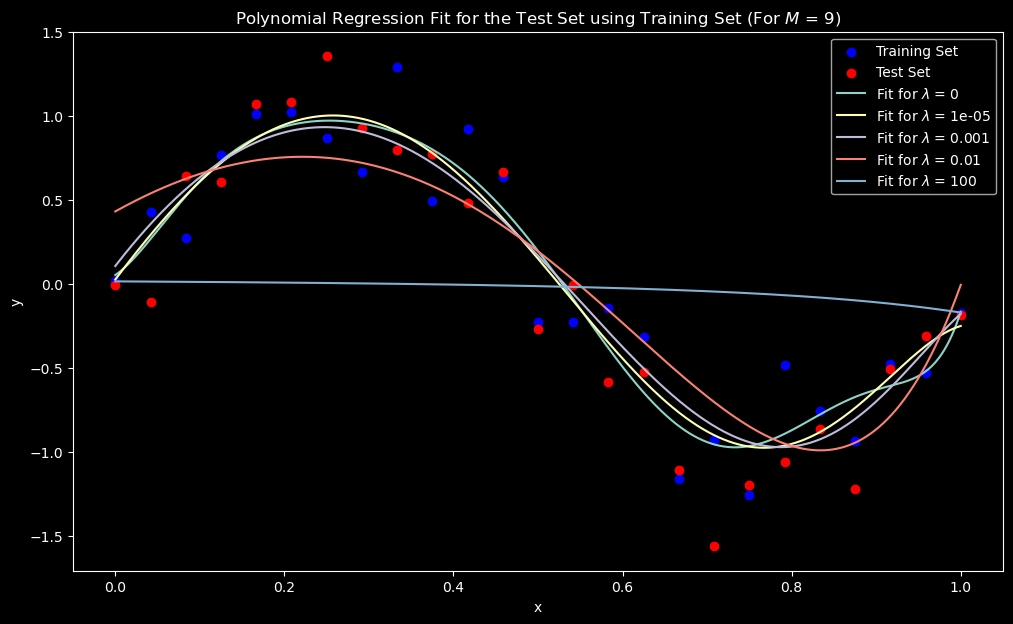

In [17]:
#We first generate our 25 datapoints for Training set and Test set as follows.
x_training, t_training = gen_sine(25)
x_test, t_test = gen_sine(25)

#Now we keep the M constant.
M = 9

#We now define a list containing the Lambda Values i.e. Regularizer Weight.
lambda_values = [0, 1e-5, 1e-3, 1e-2, 100]

#We also define an x range to define the range of our fit.
x_values = np.linspace(0, 1, 1000)

#Now we do exactly what we did except instead of looping over M, we loop over Lambda Values!

#Now we plot the Training Set and Test Set together.
plt.figure(figsize = (12, 7))
plt.scatter(x_training, t_training, color = "blue", label = "Training Set")
plt.scatter(x_test, t_test, color = "red", label = "Test Set")

#Now we define a loop where we will go over all the lambda values!
for lambda_value in lambda_values:
    #M is now given as 9.
    M = 9

    #We find the Maximum Likelihood Parameter Estimates by using our function fit_polynomial_reg.
    w = fit_polynomial_reg(x_training, t_training, M, lambda_value)

    #We again calculate the design matrix.
    phi_fit = np.array([x_values ** i for i in range(M + 1)]).T
    
    #We then find the y values i.e. the fit values by using the Design Matrix and Maximum Likelihood Parameter
    #Estimates.
    y_values = np.dot(phi_fit, w)

    #We plot our Fit.
    plt.plot(x_values, y_values, label = f"Fit for $\lambda$ = {lambda_value}")

#We also define the labels, title etc. as follows.
plt.title("Polynomial Regression Fit for the Test Set using Training Set (For $M$ = 9)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

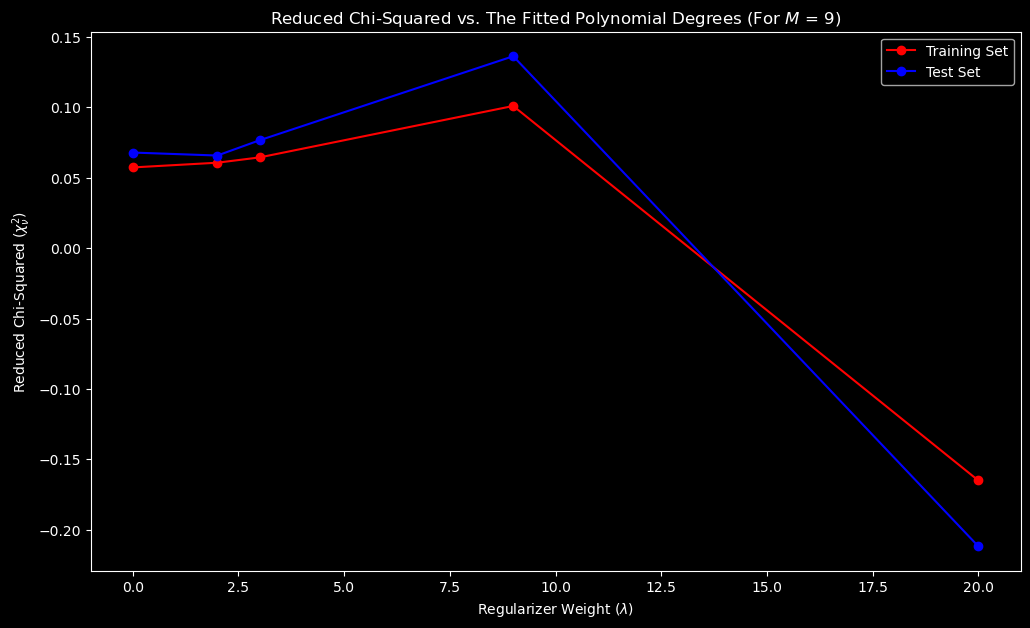

In [18]:
#Just like we did previously, we will define two lists for chi squared: Training and Test
chi_squared_training = []
chi_squared_test = []

#The algorithm we will use is for each lambda value:
    #1-) Find the w, Design Matrix and Predicted value for the t training set value.
    #2-) Find the difference between the original t training set value and predicted t training set value and 
    #add that to the chi_squared_training list. (Observed - Calculated!)
    #3-) Find the w, Design Matrix and Predicted value for the t test set value.
    #4-)

#We again loop over all the lambda values.
for lambda_value in lambda_values:
    #M is now given as 9.
    M = 9

    ########################################### t - training set ###########################################
    
    #We find the Maximum Likelihood Parameter Estimates for t training value by using our fit_polynomial_reg
    #function!
    w = fit_polynomial_reg(x_training, t_training, M, lambda_value)

    #We calculate the design matrix for t training value.
    phi_training = np.array([x_training ** i for i in range(M + 1)]).T
    
    #We then find the t training values by using the Design Matrix and Maximum Likelihood Parameter
    #Estimates i.e. Calculated t training values!
    t_training_prediction = np.dot(phi_training, w)

    #We now get the residual between the t_training value and t_training_prediction value.
    #Basically we check the (OBSERVED - CALCULATED)!!!
    residual_t_training = t_training - t_training_prediction

    #We then get the numerator of the Chi Squared for our current training data as follows.
    chi_squared_training.append(np.sum(residual_t_training**2))

    ########################################################################################################
    ############################################## t - test set ############################################

    #Since model parameters are independent of specific dataset used for training or testing once they have
    #been estimated, we don't find model parameters (w) for test set and just use the previous one!!!
    
    #Now we calculate the predicted values for the Test set!
    phi_test = np.array([x_test ** i for i in range(M + 1)]).T

    #We find the t test values by using the Design Matrix and Maximum Likelihood Parameter Estimates i.e. 
    #Calculated t test values!
    t_test_prediction = np.dot(phi_test, w)

    #We now get the residual between the t_training value and t_training_prediction value.
    #Basically we check the (OBSERVED - CALCULATED)!!!
    residual_t_test = t_test - t_test_prediction 

    #We then get the numerator of the Chi Squared for our current training data as follows.
    chi_squared_test.append(np.sum(residual_t_test**2))

    ########################################################################################################

#Now we need to calculate the Number of Degrees of Freedom for each Polynomial Fit.
#For this we do the following.
nu_training = len(x_training) - np.array(lambda_values) - 1
nu_test = len(x_test) - np.array(lambda_values) - 1

#Now we calculate the reduced Chi-Squared Values for Training and Test sets by using d.o.f.
#For this, we use the formula given on the question.
chi_squared_reduced_training = np.array(chi_squared_training) / nu_training
chi_squared_reduced_test = np.array(chi_squared_test) / nu_test

#Finally, we plot the Chi-Squared values for Training and Test sets as a function of different M values!
plt.figure(figsize = (12, 7))
plt.plot(M_list, chi_squared_reduced_training, marker = "o", color = "red", label = "Training Set")
plt.plot(M_list, chi_squared_reduced_test, marker = "o", color = "blue", label = "Test Set")
plt.xlabel("Regularizer Weight ($\lambda$)")
plt.ylabel("Reduced Chi-Squared ($\chi^2_{ν}$)")
plt.title("Reduced Chi-Squared vs. The Fitted Polynomial Degrees (For $M$ = 9)")
plt.legend()
plt.show()

*What is happening to the coefficents $\bw$ as you increase $\lambda$? Which value of $\lambda$ is most appropriate for the model $M=9$? Why?*

* From the plot above we see that **$\lambda = 0$** is **the most appropriate for the model for $M = 9$!**
* This is because as we go up on the **$\lambda$** values, **$\chi^2$ increases!**
* $\bw$ on the other hand decreases in magnitude as $\lambda$ increases!

Usage of AI: *Used on 4.1.2 to check the structure of the code, Design Matrix and Maximum Likelihood Parameter Estimate concept (also used the lecture notes from class for this) alongside implementation of them in code. Used on 4.1.3 to check the structure the loop. Used on 4.1.4 for the most of the code structure. 4.1.5 was very similar to 4.1.4 so no AI was used there.*